# YIG Material Dispersion Analysis with MEEP

**Author:** Vladislav Novitsky  
**Date:** December 2024  
**Purpose:** Calculate YIG (Yttrium Iron Garnet) material parameters and simulate electromagnetic dispersion using MEEP  

## Dependencies
- numpy
- matplotlib
- meep

## Overview
This notebook calculates the magnetic permeability parameters for YIG material and simulates the dispersion relation of a photonic crystal structure.

## Useful links
https://flex.phys.tohoku.ac.jp/japanese/pukiwiki/index.php?MEEP+%28%B8%F8%B3%AB%29

## 1. Configuration and Constants

In [3]:
import numpy as np

# Configuration Parameters
PERIOD = 5.36  # cm - Structure period
MAGNETIC_FIELD = 0.16  # Tesla - External magnetic field
RESOLUTION = 16  # pixels/um - Simulation resolution
OUTPUT_DIR = 'output/dispersion/'

# Physical Constants
SPEED_OF_LIGHT = 3e8  # m/s
PLANCK_CONSTANT = 6.626e-34  # J·s
HBAR = PLANCK_CONSTANT / (2 * np.pi)
ELECTRON_CHARGE = 1.6e-19  # C
ELECTRON_MASS = 9.1e-31  # kg
G_FACTOR = 2  # Landé g-factor

# Material Properties
SATURATION_MAGNETIZATION = 200.5e3  # A/m
NORMALIZED_MAGNETIZATION = 0.178

# MEEP Simulation Parameters
ALPHA = 0.001  # Damping parameter
EPSILON_INF = 15  # Background permittivity

## 2. Import Libraries

In [4]:
import matplotlib.pyplot as plt
import meep as mp
import os
from datetime import datetime
from typing import Dict, Tuple, List

# Set matplotlib parameters for better plots
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12
%matplotlib inline

## 3. YIG Parameter Calculations

In [5]:
def calculate_magneton_bohr() -> float:
    """Calculate the Bohr magneton."""
    return (ELECTRON_CHARGE * HBAR) / (2 * ELECTRON_MASS)


def calculate_gyromagnetic_ratio(mu_b: float) -> Tuple[float, float]:
    """Calculate gyromagnetic ratio in rad/s/T and Hz/T."""
    gamma = (G_FACTOR * mu_b) / HBAR
    gamma_hz = gamma / (2 * np.pi)
    return gamma, gamma_hz


def calculate_yig_parameters(B0: float = MAGNETIC_FIELD, 
                           Ms: float = SATURATION_MAGNETIZATION,
                           ms: float = NORMALIZED_MAGNETIZATION) -> Dict[str, float]:
    """
    Calculate YIG material parameters for MEEP simulations.
    
    Parameters:
    -----------
    B0 : float
        Magnetic field strength in Tesla
    Ms : float
        Saturation magnetization in A/m
    ms : float
        Normalized magnetization
        
    Returns:
    --------
    dict : Dictionary containing all calculated parameters
    """
    # Calculate fundamental parameters
    mu_b = calculate_magneton_bohr()
    gamma, gamma_hz = calculate_gyromagnetic_ratio(mu_b)
    
    # Precession frequencies
    omega_pr = gamma * B0
    nu_pr = omega_pr / (2 * np.pi)
    
    # Wavelength and MEEP frequency
    lambda_pr = SPEED_OF_LIGHT / nu_pr
    f_meep = (1 / (lambda_pr * 100))*PERIOD  # Convert to MEEP units
    
    # MEEP parameters
    gamma_meep = gamma_hz
    
    # Sigma frequency
    omega_s = gamma * ms
    sigma = omega_s / (2 * np.pi)
    lambda_sigma = SPEED_OF_LIGHT / sigma
    f_sigma = (1 / (lambda_sigma * 100))*PERIOD
    
    # Calculate permeability for test frequency
    test_freq = 4.28e9 * 2 * np.pi
    denominator = omega_pr**2 - test_freq**2
    mu_x = 1 + (omega_pr * omega_s) / denominator
    k_x = (test_freq * omega_s) / denominator
    
    return {
        'mu_b': mu_b,
        'gamma': gamma,
        'gamma_hz': gamma_hz,
        'omega_pr': omega_pr,
        'nu_pr': nu_pr,
        'lambda_pr': lambda_pr,
        'f_meep': f_meep,
        'gamma_meep': gamma_meep,
        'sigma': sigma,
        'f_sigma': f_sigma,
        'omega_s': omega_s,
        'mu_x': mu_x,
        'k_x': k_x,
        'denominator': denominator
    }

In [6]:
def print_parameters(params: Dict[str, float]) -> None:
    """Pretty print the calculated parameters."""
    print("YIG Material Parameters:")
    print("=" * 50)
    print(f"Magnetic Induction (Tesla): {MAGNETIC_FIELD:.2f}")
    print(f"Magneton Bohr: {params['mu_b']:.3e}")
    print(f"Gyromagnetic Ratio (rad/Hz/T): {params['gamma']:.3e}")
    print(f"Gyromagnetic Ratio (Hz/T): {params['gamma_hz']:.3e}")
    print(f"Precession Frequency (rad/s): {params['omega_pr']:.3e}")
    print(f"Precession Frequency (Hz): {params['nu_pr']:.3e}")
    print(f"Wavelength (m): {params['lambda_pr']:.3f}")
    print(f"MEEP Frequency (cm): {params['f_meep']:.3f}")
    print(f"MEEP Gamma: {params['gamma_meep']:.3e}")
    print(f"Sigma: {params['sigma']:.3e}")
    print(f"MEEP Sigma Frequency (cm): {params['f_sigma']:.3f}")
    print(f"Mu(x): {params['mu_x']:.3f}")
    print(f"k(x): {params['k_x']:.3f}")

In [7]:
# Calculate and display parameters
yig_params = calculate_yig_parameters()
print_parameters(yig_params)

YIG Material Parameters:
Magnetic Induction (Tesla): 0.16
Magneton Bohr: 9.271e-24
Gyromagnetic Ratio (rad/Hz/T): 1.758e+11
Gyromagnetic Ratio (Hz/T): 2.798e+10
Precession Frequency (rad/s): 2.813e+10
Precession Frequency (Hz): 4.477e+09
Wavelength (m): 0.067
MEEP Frequency (cm): 0.800
MEEP Gamma: 2.798e+10
Sigma: 4.981e+09
MEEP Sigma Frequency (cm): 0.890
Mu(x): 13.906
k(x): 12.337


## 4. Permeability Analysis and Visualization

In [8]:
def calculate_permeability_spectrum(omega_pr: float, omega_s: float, 
                                  freq_range: Tuple[float, float] = (0, 2),
                                  num_points: int = 50) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Calculate permeability components over a frequency range.
    
    Parameters:
    -----------
    omega_pr : float
        Precession frequency
    omega_s : float
        Saturation frequency
    freq_range : tuple
        Frequency range as (min, max) relative to omega_pr
    num_points : int
        Number of frequency points
        
    Returns:
    --------
    tuple : (frequencies, mu_values, k_values)
    """
    freq_min = freq_range[0] * omega_pr
    freq_max = freq_range[1] * omega_pr
    frequencies = np.linspace(freq_min, freq_max, num_points)
    
    mu_values = []
    k_values = []
    
    for freq in frequencies:
        denominator = omega_pr**2 - freq**2
        mu_x = 1 + (omega_pr * omega_s) / denominator
        k_x = (freq * omega_s) / denominator
        mu_values.append(mu_x)
        k_values.append(k_x)
    
    return frequencies, np.array(mu_values), np.array(k_values)

In [9]:
def plot_permeability_components(frequencies: np.ndarray, mu_values: np.ndarray, 
                                k_values: np.ndarray, omega_pr: float) -> Tuple[plt.Figure, plt.Axes]:
    """
    Create a well-labeled plot of magnetic permeability components.
    
    Parameters:
    -----------
    frequencies : np.ndarray
        Frequency array
    mu_values : np.ndarray
        Diagonal permeability component
    k_values : np.ndarray
        Off-diagonal permeability component
    omega_pr : float
        Precession frequency for reference line
        
    Returns:
    --------
    tuple : (figure, axes)
    """
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Plot permeability components
    ax.semilogx(frequencies, mu_values, 'b-', label='μ(ω)', linewidth=2)
    ax.semilogx(frequencies, k_values, 'r-', label='κ(ω)', linewidth=2)
    
    # Add reference lines
    ax.axvline(x=omega_pr, color='g', linestyle='--', label='ω_pr', linewidth=1.5)
    ax.axhline(y=0, color='k', linestyle=':', alpha=0.5)
    
    # Formatting
    ax.set_xlabel('Frequency ω (rad/s)', fontsize=14)
    ax.set_ylabel('Permeability Components', fontsize=14)
    ax.set_title('YIG Magnetic Permeability vs Frequency', fontsize=16)
    ax.legend(fontsize=12, loc='best')
    ax.grid(True, alpha=0.3, which='both')
    
    # Set reasonable y-limits
    y_min = min(np.min(mu_values), np.min(k_values))
    y_max = max(np.max(mu_values), np.max(k_values))
    ax.set_ylim(y_min * 1.1, y_max * 1.1)
    
    plt.tight_layout()
    return fig, ax

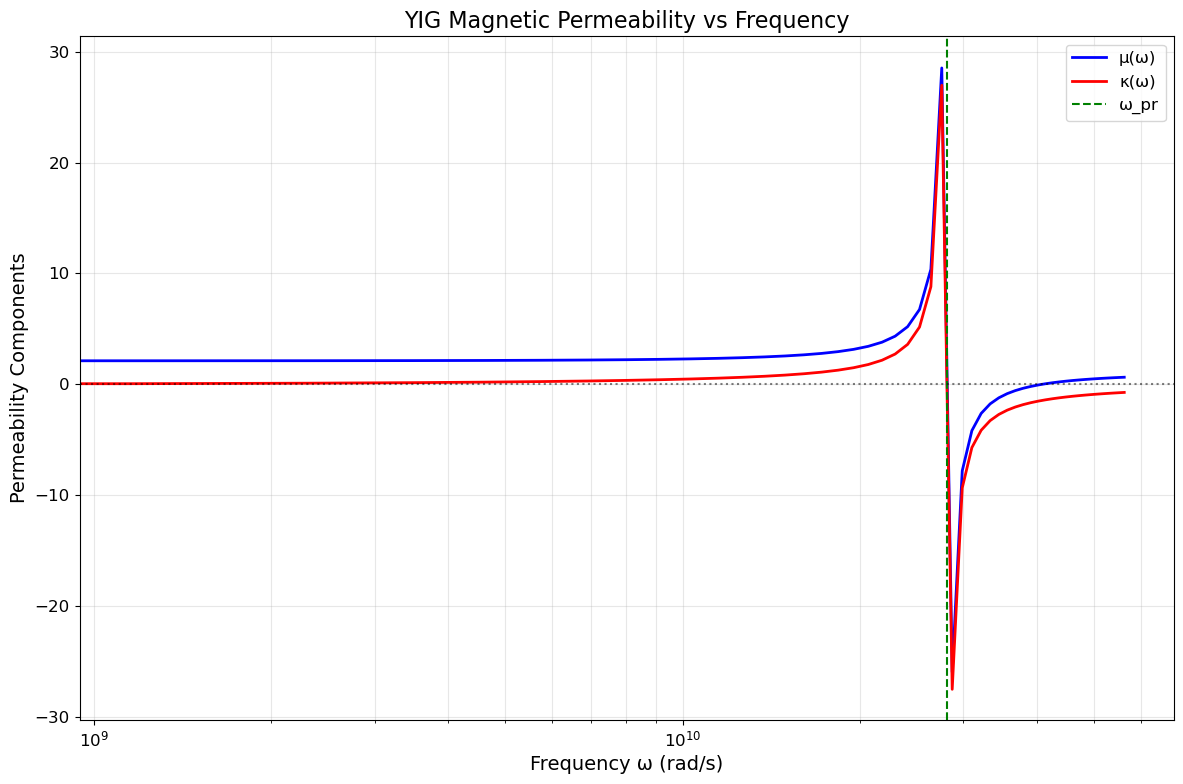

In [10]:
# Calculate and plot permeability spectrum
frequencies, mu_vals, k_vals = calculate_permeability_spectrum(
    yig_params['omega_pr'], 
    yig_params['omega_s']
)

fig, ax = plot_permeability_components(frequencies, mu_vals, k_vals, yig_params['omega_pr'])
plt.show()

## 5. MEEP Simulation Setup

In [11]:
def create_yig_material(f0: float, gamma: float, sigma: float, 
                       alpha: float = ALPHA, epsilon: float = EPSILON_INF) -> mp.Medium:
    """
    Create YIG material with gyrotropic susceptibility for MEEP.
    
    Parameters:
    -----------
    f0 : float
        Natural frequency (MEEP units)
    gamma : float
        Damping rate
    sigma : float
        Sigma parameter (MEEP units)
    alpha : float
        Alpha parameter for saturated susceptibility
    epsilon : float
        Background permittivity
        
    Returns:
    --------
    mp.Medium : MEEP material with gyrotropic properties
    """
    susc = [mp.GyrotropicSaturatedSusceptibility(
        frequency=f0,
        gamma=gamma,
        sigma=sigma,
        alpha=alpha,
        bias=mp.Vector3(0, 0, 1)
    )]
    
    return mp.Medium(epsilon=epsilon, H_susceptibilities=susc)

In [36]:
def create_photonic_crystal_geometry(material: mp.Medium, 
                                   N: int = 3, 
                                   r: float = 0.11) -> List[mp.Cylinder]:
    """
    Create photonic crystal geometry with cylindrical holes.
    
    Parameters:
    -----------
    material : mp.Medium
        Material for the cylinders
    N : int
        Number of cylinders on each side
    r : float
        Radius of cylinders
        
    Returns:
    --------
    list : List of cylinder objects
    """
    geometry = []
    for i in range(-N, N + 1):
        if i == 0:
            continue
        geometry.append(
            mp.Cylinder(
                r,
                material=material,
                center=mp.Vector3(0, i, 0)
            )
        )
    return geometry

In [37]:
def create_photonic_crystal_geometry_single(material: mp.Medium, 
                                   N: int = 3, 
                                   r: float = 0.11) -> List[mp.Cylinder]:
    """
    Create photonic crystal geometry with cylindrical holes.
    
    Parameters:
    -----------
    material : mp.Medium
        Material for the cylinders
    N : int
        Number of cylinders on each side
    r : float
        Radius of cylinders
        
    Returns:
    --------
    list : List of cylinder objects
    """
    geometry = []
    geometry.append(
        mp.Cylinder(
            r,
            material=material,
            center=mp.Vector3(0, 0, 0)
        )
    )
    return geometry

## 6. Dispersion Calculation

### Waveguide case
cell = 1, 7 0
source: fcen 0.5 df 2, center same

### Single crystal case
cell = 1,1 0
source: fcen 0.5 df 2.5, center same
investigate source center correlation to interpolation plot

In [44]:
def setup_simulation(yig_params: Dict[str, float]) -> mp.Simulation:
    """
    Set up MEEP simulation with YIG material.
    
    Parameters:
    -----------
    yig_params : dict
        Dictionary of YIG parameters
        
    Returns:
    --------
    mp.Simulation : Configured simulation object
    """
    # Material parameters
    f0 = yig_params['f_meep']
    gamma = 2.8e-5
    sigma = yig_params['f_sigma']
    print(yig_params)
    
    # Create material
    yig_material = create_yig_material(f0, gamma, sigma)
    
    # Geometry
    geometry = create_photonic_crystal_geometry(yig_material, 3)
    
    # Cell
    cell = mp.Vector3(1, 7)
    
    # Source
    fcen = 0.5
    df = 2
    src = [mp.Source(
        src=mp.GaussianSource(fcen, fwidth=df),
        component=mp.Ez,
        center=mp.Vector3(0, 0.25)
    )]
    
    # Create simulation
    sim = mp.Simulation(
        cell_size=cell,
        geometry=geometry,
        sources=src,
        resolution=RESOLUTION
    )
    
    return sim

### Waveguide case

Gamma, X

### SIngle crystal case

  Gamma = mp.Vector3(x=0,y=0,z=0)
X = mp.Vector3(x=0.5,y=0,z=0)
    M =  mp.Vector3(x=0.5,y=0.5,z=0)
    k_points = mp.interpolate(k_interp, [Gamma, X, M, Gamma])
    # mp.Vector3(0), mp.Vector3(0.5), mp.Vector3(0.5, 0.5), mp.Vector3(0)

In [45]:
def run_dispersion_analysis(sim: mp.Simulation, k_interp: int = 19) -> np.ndarray:
    """
    Run k-points analysis for dispersion calculation.
    
    Parameters:
    -----------
    sim : mp.Simulation
        Configured simulation object
    k_interp : int
        Number of k-points to interpolate
        
    Returns:
    --------
    np.ndarray : Array of frequencies for each k-point
    """
    print("Running dispersion analysis...")
    Gamma = mp.Vector3(x=0,y=0,z=0)
    X = mp.Vector3(x=0.5,y=0,z=0)
    M =  mp.Vector3(x=0.5,y=0.5,z=0)
    k_points = mp.interpolate(k_interp, [Gamma, X])
    # mp.Vector3(0), mp.Vector3(0.5), mp.Vector3(0.5, 0.5), mp.Vector3(0)
    freqs_result = sim.run_k_points(200, k_points)
    print("Dispersion analysis complete.")
    return freqs_result

In [46]:
def plot_dispersion(freqs_result: np.ndarray, 
                   freq_cutoff: float = 0.8) -> Tuple[plt.Figure, plt.Axes]:
    """
    Plot dispersion diagram.
    
    Parameters:
    -----------
    freqs_result : np.ndarray
        Frequency results from k-points analysis
    freq_cutoff : float
        Maximum frequency to display
        
    Returns:
    --------
    tuple : (figure, axes)
    """
    fig, ax = plt.subplots(figsize=(10, 8))
    
    for i in range(len(freqs_result)):
        for freq in freqs_result[i]:
            if np.real(freq) > freq_cutoff:
                continue
            ax.scatter(i, np.real(freq), color='b', marker='.', s=20)
    
    ax.set_xlabel('k-point index', fontsize=14)
    ax.set_ylabel('Frequency (c/a)', fontsize=14)
    ax.set_title('Photonic Band Structure', fontsize=16)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig, ax

## 7. File I/O Utilities

In [49]:
def save_figure(fig: plt.Figure, filename: str, output_dir: str = OUTPUT_DIR) -> None:
    """
    Save figure with proper error handling.
    
    Parameters:
    -----------
    fig : plt.Figure
        Figure to save
    filename : str
        Output filename
    output_dir : str
        Output directory path
    """
    try:
        os.makedirs(output_dir, exist_ok=True)
        filepath = os.path.join(output_dir, filename)
        
        # Add timestamp to filename
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        base, ext = os.path.splitext(filename)
        filepath = os.path.join(output_dir, f"{base}_{timestamp}{ext}")
        
        fig.savefig(filepath, dpi=300, bbox_inches='tight')
        print(f"Figure saved to: {filepath}")
        
    except Exception as e:
        print(f"Error saving figure: {e}")

## 8. Main Execution

investigate harminv and H_susceptibilities

Starting YIG dispersion analysis...

{'mu_b': 9.270862882873833e-24, 'gamma': 175824175824.17584, 'gamma_hz': 27983286697.47611, 'omega_pr': 28131868131.868134, 'nu_pr': 4477325871.596177, 'lambda_pr': 0.0670042808148448, 'f_meep': 0.799948889058517, 'gamma_meep': 27983286697.47611, 'sigma': 4981025032.150746, 'f_sigma': 0.8899431390776001, 'omega_s': 31296703296.703297, 'mu_x': 13.905709598032267, 'k_x': 12.336925804305192, 'denominator': 6.822055954515663e+19}
Running dispersion analysis...
-----------
Initializing structure...
time for choose_chunkdivision = 6.29425e-05 s
Working in 2D dimensions.
Computational cell is 1 x 7 x 0 with resolution 16
     cylinder, center = (0,-3,0)
          radius 0.11, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (15,15,15)
     cylinder, center = (0,-2,0)
          radius 0.11, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (15,15,15)
     cylinder, center = (0,-1,0)
          radius 0

FloatProgress(value=0.0, description='0% done ', max=205.0)

harminv0:, frequency, imag. freq., Q, |amp|, amplitude, error
harminv0:, 0.11795158059423841, 0.0005441488669480842, -108.3817202963062, 0.00319746072840155, 0.0025877438162368966+0.0018781206167863326i, 0.0009408251788449777+0.0i
harminv0:, 0.22992981650611166, -0.00011460113716887573, 1003.1742362525082, 0.014864068441480503, 0.014000169745241063-0.00499357364394012i, 0.00014473402179101408+0.0i
harminv0:, 0.3292104768341384, 1.496902532870915e-05, -10996.389865235393, 0.06462768962151968, -0.02869448746215937-0.05790824341231101i, 2.270392048034324e-05+0.0i
harminv0:, 0.47047632714222254, -0.00014410948514602149, 1632.357254852115, 0.019620727745127187, -0.005756494037247375+0.018757284815440086i, 0.00010120262657726877+0.0i
harminv0:, 0.47992205606990457, -0.00052756748040795, 454.84423689155096, 0.01477547618333983, 0.006589774183603702+0.01322458213530971i, 0.00034577362119070923+0.0i
harminv0:, 0.4863668853733385, 4.566971940565665e-06, -53248.28920594344, 0.04697251782660671, -

FloatProgress(value=0.0, description='0% done ', max=205.0)

harminv1:, frequency, imag. freq., Q, |amp|, amplitude, error
harminv1:, 0.1208201858851885, -0.00014635728240712832, 412.75768413456126, 0.015053006219843677, 0.0032317127945356997+0.014702007640736916i, 0.00022879287040316904+0.0i
harminv1:, 0.21735135154074472, -0.000605319522734488, 179.53439743598176, 0.0057699281260852765, 0.004749759009215336-0.003275951760109984i, 0.000409743900740406+0.0i
harminv1:, 0.23045772457281716, 7.241694633912381e-05, -1591.1864295796095, 0.029663983620396295, 0.02647292827604803-0.01338416948197968i, 3.7350517466553656e-05+0.0i
harminv1:, 0.329634129935884, 1.7497350573277414e-05, -9419.544077699202, 0.13509787297129822, -0.06365593543533388-0.11916105557279037i, 8.138793889907781e-06+0.0i
harminv1:, 0.47098959580590993, -0.00022831763941832467, 1031.4349714849682, 0.04042555926297364, -0.014690416227599559+0.03766188408436404i, 4.179711723390154e-05+0.0i
harminv1:, 0.4803054943071151, -0.0005618952873283136, 427.39768880324687, 0.02931833425293952, 0

FloatProgress(value=0.0, description='0% done ', max=205.0)

harminv2:, frequency, imag. freq., Q, |amp|, amplitude, error
harminv2:, 0.12532069819678593, 0.00010545214829611869, -594.2064728964774, 0.013522229921045754, 0.00546423044072477+0.01236902937696737i, 0.0009560390566728177+0.0i
harminv2:, 0.2327028986582181, -0.00010276164761737458, 1132.2458526777918, 0.033099924822263475, 0.030580049951884066-0.012667500470880944i, 0.00021387623045106459+0.0i
harminv2:, 0.33111391628165504, 2.8379410834344928e-06, -58336.99617909951, 0.13890182926597086, -0.060500075605780246-0.12503383152222358i, 4.386597750928554e-05+0.0i
harminv2:, 0.4725186748480146, 0.00010355178987043421, -2281.557254776755, 0.029774725001540527, -0.017371876554983248+0.02418164911406552i, 9.000929997573272e-05+0.0i
harminv2:, 0.4870214531865964, -0.0003090050277869914, 788.0477814139618, 0.125421280990528, -0.05675876248447436+0.11184337533594023i, 5.785920836376656e-05+0.0i
harminv2:, 0.5881368617124856, 0.0006256295775559655, -470.03601077338294, 0.03239394321166244, 0.0318

FloatProgress(value=0.0, description='0% done ', max=205.0)

harminv3:, frequency, imag. freq., Q, |amp|, amplitude, error
run 3 finished at t = 205.0 (6560 timesteps)
freqs:, 4, 0.07142857142857142, 0.0, 0.0, 
freqs-im:, 4, 0.07142857142857142, 0.0, 0.0, 


FloatProgress(value=0.0, description='0% done ', max=205.0)

harminv4:, frequency, imag. freq., Q, |amp|, amplitude, error
harminv4:, 1.0180500440212361, 0.008899891233570332, -57.19452166904905, 0.001498441971998209, -0.0014575463124422451-0.0003476882087904255i, 3.468113945918633e-06+0.0i
run 4 finished at t = 205.0 (6560 timesteps)
freqs:, 5, 0.09523809523809523, 0.0, 0.0, 1.0180500440212361
freqs-im:, 5, 0.09523809523809523, 0.0, 0.0, 0.008899891233570332


FloatProgress(value=0.0, description='0% done ', max=205.0)

harminv5:, frequency, imag. freq., Q, |amp|, amplitude, error
run 5 finished at t = 205.0 (6560 timesteps)
freqs:, 6, 0.11904761904761904, 0.0, 0.0, 
freqs-im:, 6, 0.11904761904761904, 0.0, 0.0, 


FloatProgress(value=0.0, description='0% done ', max=205.0)

harminv6:, frequency, imag. freq., Q, |amp|, amplitude, error
run 6 finished at t = 205.0 (6560 timesteps)
freqs:, 7, 0.14285714285714285, 0.0, 0.0, 
freqs-im:, 7, 0.14285714285714285, 0.0, 0.0, 


FloatProgress(value=0.0, description='0% done ', max=205.0)

harminv7:, frequency, imag. freq., Q, |amp|, amplitude, error
harminv7:, 0.35136290711554885, -0.0007052318349052157, 249.11163232071948, 0.2884093076891852, -0.2440762556269017-0.15364475324887097i, 0.00017762567548076948+0.0i
harminv7:, 0.49679310127794, 0.001118744375626898, -222.03155256068115, 0.0741251142731875, 0.02984955935343946+0.06784936530593784i, 0.00016796616483194524+0.0i
harminv7:, 0.8605813770156074, 0.006587602782977731, -65.31825045973758, 0.007777239556190431, -0.00035786634366442+0.007769001660087697i, 0.0001130314386180974+0.0i
harminv7:, 0.8892715904316904, -0.006800971942270761, 65.3782722513904, 22.753123813357682, 5.731945740349733-22.019297020923965i, 7.634422284015395e-05+0.0i
harminv7:, 0.9980452429570341, 0.007064882630025485, -70.63424088005223, 0.043136880748623596, 0.009324490179753344+0.04211703175211492i, 1.0139378371373264e-06+0.0i
run 7 finished at t = 205.0 (6560 timesteps)
freqs:, 8, 0.16666666666666666, 0.0, 0.0, 0.35136290711554885, 0.4967931012

FloatProgress(value=0.0, description='0% done ', max=205.0)

harminv8:, frequency, imag. freq., Q, |amp|, amplitude, error
harminv8:, 0.19418213774713258, 0.0005355333518611374, -181.2978940268538, 0.016193174633132707, 0.0157713674537596+0.003671903230972326i, 0.00013698245927398715+0.0i
harminv8:, 0.268006945925094, 0.0004971109345946723, -269.5645250125286, 0.021298243216018566, 0.014937874484194851-0.015181405402106921i, 0.0001180745508379635+0.0i
harminv8:, 0.35838194868716644, 1.9951794205399253e-05, -8981.196001665428, 0.19575887703193534, -0.16648386193208659-0.1029789379095663i, 1.326686815201351e-05+0.0i
harminv8:, 0.5021983937163622, -7.959898766658352e-05, 3154.552642176317, 0.1422228708833488, 0.02798983772586356+0.1394414356867482i, 1.4772864821298372e-05+0.0i
harminv8:, 0.5848870058254594, 0.0002630706570745179, -1111.6538277771192, 0.0629328458300576, 0.06288232952893566+0.0025210547959424517i, 1.9318523338351306e-05+0.0i
harminv8:, 0.6189675135113887, -0.001736933867510258, 178.1782038710041, 0.041068292383340546, 0.024788861350

FloatProgress(value=0.0, description='0% done ', max=205.0)

harminv9:, frequency, imag. freq., Q, |amp|, amplitude, error
harminv9:, 0.16987082073297416, -2.2297800215131002e-05, 3809.138549409506, 0.005510200998493281, 0.005124561095299801+0.0020251391617210055i, 0.00011006886651602577+0.0i
harminv9:, 0.19767643396477935, -9.065752355035081e-05, 1090.237336204042, 0.0011307608093155301, 0.0011298008021914394-4.6584925152808596e-05i, 0.0005532776705214043+0.0i
harminv9:, 0.2081348236501997, -1.292121116641804e-06, 80539.98227005909, 0.022957347929854634, 0.022691313376435606-0.003484841635540334i, 2.3059108519096667e-05+0.0i
harminv9:, 0.2609245215756152, -0.00013741756268602514, 949.3856406541777, 0.004132833970208624, 0.0025314757308448803-0.0032667946445183475i, 6.269733709567029e-05+0.0i
harminv9:, 0.27542306317837534, -2.4897945611443673e-05, 5531.039939531889, 0.027714714925033995, 0.009516194653086838-0.026029741886935097i, 1.3892822201271778e-05+0.0i
harminv9:, 0.3102481738049978, -0.0002913338874063452, 532.461528192001, 0.001791392988

FloatProgress(value=0.0, description='0% done ', max=205.0)

harminv10:, frequency, imag. freq., Q, |amp|, amplitude, error
harminv10:, 0.28439157337902116, 0.0009803428686449747, -145.04699451331035, 0.01323835332332184, 0.00947395107350625-0.009246526362365285i, 0.0008188875174966445+0.0i
harminv10:, 0.3752748237452079, -6.456179357514815e-06, 29063.227875508004, 0.23669660048537444, -0.21349163581221436-0.10220862057359835i, 5.814385585714728e-05+0.0i
harminv10:, 0.5144575025240515, 0.00029840428472143165, -862.0142686696194, 0.08790929847113607, 0.01358735177462122+0.08685291376482418i, 9.588889990320477e-05+0.0i
harminv10:, 0.5827977726811625, 0.0004582856672001719, -635.8455155729381, 0.051121755510172194, 0.050769593735830544+0.00599017848987297i, 0.00013142495933396556+0.0i
harminv10:, 0.6443100164324369, 0.0005534180512945195, -582.1187210331402, 0.02643825604388101, 0.010602430369198664-0.024219204217069242i, 0.00024565660811525273+0.0i
harminv10:, 0.6858494935702332, -0.0007423349416110699, 461.9542036386918, 0.07356845948312173, 0.01

FloatProgress(value=0.0, description='0% done ', max=205.0)

harminv11:, frequency, imag. freq., Q, |amp|, amplitude, error
harminv11:, 0.992810990030047, 0.009263194429276202, -53.589018216668386, 0.02513989891447214, 0.01890973221779204+0.01656612642959347i, 1.687683326566327e-06+0.0i
run 11 finished at t = 205.0 (6560 timesteps)
freqs:, 12, 0.26190476190476186, 0.0, 0.0, 0.992810990030047
freqs-im:, 12, 0.26190476190476186, 0.0, 0.0, 0.009263194429276202


FloatProgress(value=0.0, description='0% done ', max=205.0)

harminv12:, frequency, imag. freq., Q, |amp|, amplitude, error
run 12 finished at t = 205.0 (6560 timesteps)
freqs:, 13, 0.2857142857142857, 0.0, 0.0, 
freqs-im:, 13, 0.2857142857142857, 0.0, 0.0, 


FloatProgress(value=0.0, description='0% done ', max=205.0)

harminv13:, frequency, imag. freq., Q, |amp|, amplitude, error
run 13 finished at t = 205.0 (6560 timesteps)
freqs:, 14, 0.30952380952380953, 0.0, 0.0, 
freqs-im:, 14, 0.30952380952380953, 0.0, 0.0, 


FloatProgress(value=0.0, description='0% done ', max=205.0)

harminv14:, frequency, imag. freq., Q, |amp|, amplitude, error
run 14 finished at t = 205.0 (6560 timesteps)
freqs:, 15, 0.3333333333333333, 0.0, 0.0, 
freqs-im:, 15, 0.3333333333333333, 0.0, 0.0, 


FloatProgress(value=0.0, description='0% done ', max=205.0)

harminv15:, frequency, imag. freq., Q, |amp|, amplitude, error
run 15 finished at t = 205.0 (6560 timesteps)
freqs:, 16, 0.3571428571428571, 0.0, 0.0, 
freqs-im:, 16, 0.3571428571428571, 0.0, 0.0, 


FloatProgress(value=0.0, description='0% done ', max=205.0)

harminv16:, frequency, imag. freq., Q, |amp|, amplitude, error
run 16 finished at t = 205.0 (6560 timesteps)
freqs:, 17, 0.38095238095238093, 0.0, 0.0, 
freqs-im:, 17, 0.38095238095238093, 0.0, 0.0, 


FloatProgress(value=0.0, description='0% done ', max=205.0)

harminv17:, frequency, imag. freq., Q, |amp|, amplitude, error
run 17 finished at t = 205.0 (6560 timesteps)
freqs:, 18, 0.40476190476190477, 0.0, 0.0, 
freqs-im:, 18, 0.40476190476190477, 0.0, 0.0, 


FloatProgress(value=0.0, description='0% done ', max=205.0)

harminv18:, frequency, imag. freq., Q, |amp|, amplitude, error
run 18 finished at t = 205.0 (6560 timesteps)
freqs:, 19, 0.42857142857142855, 0.0, 0.0, 
freqs-im:, 19, 0.42857142857142855, 0.0, 0.0, 


FloatProgress(value=0.0, description='0% done ', max=205.0)

harminv19:, frequency, imag. freq., Q, |amp|, amplitude, error
run 19 finished at t = 205.0 (6560 timesteps)
freqs:, 20, 0.45238095238095233, 0.0, 0.0, 
freqs-im:, 20, 0.45238095238095233, 0.0, 0.0, 


FloatProgress(value=0.0, description='0% done ', max=205.0)

harminv20:, frequency, imag. freq., Q, |amp|, amplitude, error
run 20 finished at t = 205.0 (6560 timesteps)
freqs:, 21, 0.47619047619047616, 0.0, 0.0, 
freqs-im:, 21, 0.47619047619047616, 0.0, 0.0, 


FloatProgress(value=0.0, description='0% done ', max=205.0)

harminv21:, frequency, imag. freq., Q, |amp|, amplitude, error
run 21 finished at t = 205.0 (6560 timesteps)
freqs:, 22, 0.5, 0.0, 0.0, 
freqs-im:, 22, 0.5, 0.0, 0.0, 
Dispersion analysis complete.
Figure saved to: output/dispersion/dispersion_diagram_waveguide_20250613_145830.png


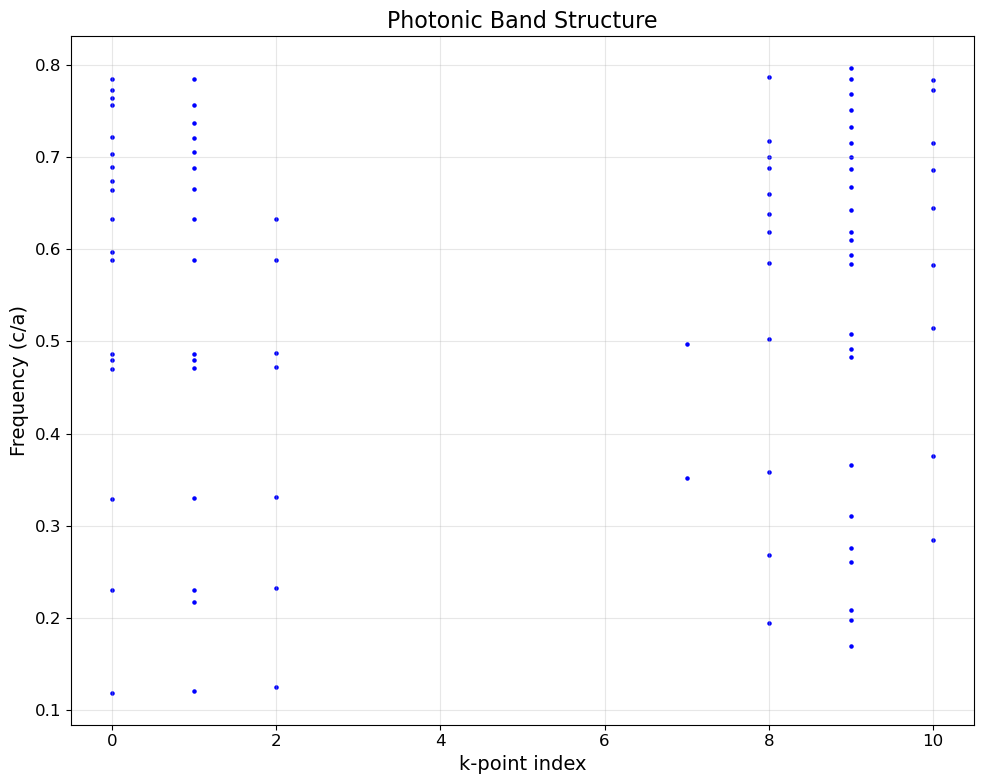

In [50]:
# Run the complete analysis
print("Starting YIG dispersion analysis...\n")

# Set up simulation
sim = setup_simulation(yig_params)

# Run dispersion analysis
freqs_result = run_dispersion_analysis(sim, 20)

# # Plot results
fig_dispersion, ax_dispersion = plot_dispersion(freqs_result)
save_figure(fig_dispersion, "dispersion_diagram_waveguide.png")

# plt.show()

## 9. Testing and Validation

In [17]:
def test_calculations():
    """Test key calculations with expected value ranges."""
    params = calculate_yig_parameters()
    
    # Test precession frequency is in expected range
    assert 2e10 < params['omega_pr'] < 3e10, "Precession frequency out of range"
    
    # Test MEEP frequency is positive
    assert params['f_meep'] > 0, "MEEP frequency must be positive"
    
    # Test permeability calculation
    assert params['mu_x'] > 0, "Diagonal permeability should be positive"
    
    # Test gyromagnetic ratio
    assert params['gamma'] > 1e11, "Gyromagnetic ratio seems too small"
    
    print("✓ All tests passed!")
    return True

# Run tests
test_calculations()

✓ All tests passed!


True

## 10. Summary and Next Steps

This notebook has:
1. Calculated YIG material parameters from physical constants
2. Analyzed the frequency-dependent permeability
3. Set up and run a MEEP simulation for photonic band structure
4. Generated dispersion diagrams

## 10. Continuous Wave Analysis of 2D Photonic Crystal

In [10]:
def create_2d_photonic_crystal_geometry(material: mp.Medium, 
                                       w: float = 1.2, 
                                       r: float = 0.11, 
                                       d: float = 1, 
                                       N: int = 10) -> List[mp.Cylinder]:
    """
    Create a 2D photonic crystal geometry with cylindrical holes.
    
    Parameters:
    -----------
    material : mp.Medium
        Material for the cylinders
    w : float
        Width of waveguide
    r : float
        Radius of holes
    d : float
        Defect spacing (ordinary spacing = 1)
    N : int
        Number of holes on either side of defect
        
    Returns:
    --------
    list : List of cylinder objects
    """
    geometry = []
    
    for i in range(-N, N + 1):
        for j in range(-N, N + 1):
            # Skip center row to create waveguide
            if j == 0:
                continue

            # Shift every other row for hexagonal lattice
            if j % 2 == 0:
                offset = 0.5 * d
            else:
                offset = 0
            
            geometry.append(
                mp.Cylinder(
                    r, 
                    material=material, 
                    center=mp.Vector3(
                        i * d + offset, 
                        j * d, 
                        0
                    )
                )
            )
    
    return geometry

In [11]:
def setup_continuous_wave_simulation(yig_params: Dict[str, float]) -> mp.Simulation:
    """
    Set up MEEP simulation with continuous wave source for 2D photonic crystal.
    
    Parameters:
    -----------
    yig_params : dict
        Dictionary of YIG parameters
        
    Returns:
    --------
    mp.Simulation : Configured simulation object
    """
    # Simulation parameters
    w = 1.2      # width of waveguide
    r = 0.11     # radius of holes
    d = 1        # defect spacing
    N = 10       # number of holes on either side
    sy = 20      # size of cell in y direction
    pad = 2      # padding between last hole and PML edge
    dpml = 1     # PML thickness
    
    sx = 2 * (pad + dpml + N) + d - 1  # size of cell in x direction
    cell = mp.Vector3(sx, sy, 0)
    
    # Create YIG material with updated parameters
    f0 = yig_params['f_meep'] * PERIOD
    gamma = 2.8e-5
    sigma = yig_params['f_sigma'] * PERIOD
    alpha = 0.001
    
    susc = [mp.GyrotropicSaturatedSusceptibility(
        frequency=f0, 
        gamma=gamma, 
        sigma=sigma, 
        alpha=alpha,
        bias=mp.Vector3(0, 0, 1))
    ]
    
    gss_material = mp.Medium(epsilon=EPSILON_INF, E_susceptibilities=susc)
    
    # Create geometry
    geometry = create_2d_photonic_crystal_geometry(gss_material, w, r, d, N)
    
    # Source frequency
    s_frq = 0.568
    
    sources = [
        mp.Source(
            mp.ContinuousSource(frequency=s_frq),
            component=mp.Ez, 
            center=mp.Vector3(0, 0, 0)
        )
    ]
    
    # Create simulation
    sim = mp.Simulation(
        cell_size=cell,
        geometry=geometry,
        sources=sources,
        boundary_layers=[mp.PML(dpml)],
        resolution=RESOLUTION,
    )
    
    return sim

In [21]:
def run_continuous_wave_analysis(sim: mp.Simulation, 
                                runtime: float = 100,
                                output_dir: str = OUTPUT_DIR) -> Tuple[np.ndarray, np.ndarray]:
    """
    Run continuous wave simulation and extract field data.
    
    Parameters:
    -----------
    sim : mp.Simulation
        Configured simulation object
    runtime : float
        Simulation runtime
    output_dir : str
        Output directory for files
        
    Returns:
    --------
    tuple : (epsilon_data, ez_data)
    """
    print("Running continuous wave analysis...")
    
    # Set output directory
    sim.use_output_directory(output_dir)
    
    # Run simulation with field outputs
    sim.run(
        mp.at_beginning(mp.output_epsilon), 
        mp.at_every(1.2, mp.output_png(mp.Ez, "-C $EPS -Zc dkbluered")), 
        until=runtime
    )
    
    # Extract field data
    cell = sim.cell_size
    eps_data = sim.get_array(center=mp.Vector3(), size=cell, component=mp.Dielectric)
    ez_data = sim.get_array(center=mp.Vector3(), size=cell, component=mp.Ez)
    
    print("Continuous wave analysis complete.")
    return eps_data, ez_data

In [22]:
def plot_field_distributions(eps_data: np.ndarray, 
                           ez_data: np.ndarray,
                           output_dir: str = OUTPUT_DIR) -> Tuple[plt.Figure, plt.Figure]:
    """
    Create visualizations of epsilon and electric field distributions.
    
    Parameters:
    -----------
    eps_data : np.ndarray
        Permittivity distribution data
    ez_data : np.ndarray
        Electric field Ez component data
    output_dir : str
        Output directory for saving figures
        
    Returns:
    --------
    tuple : (epsilon_figure, field_figure)
    """
    # Plot epsilon distribution
    fig_eps, ax_eps = plt.subplots(figsize=(12, 8))
    im_eps = ax_eps.imshow(eps_data.transpose(), 
                          interpolation='spline36', 
                          cmap='binary',
                          aspect='auto')
    ax_eps.set_title('Permittivity Distribution', fontsize=16)
    ax_eps.axis('off')
    plt.colorbar(im_eps, ax=ax_eps, label='Relative Permittivity')
    
    # Plot electric field with epsilon overlay
    fig_field, ax_field = plt.subplots(figsize=(12, 8))
    
    # Background: epsilon
    ax_field.imshow(eps_data.transpose(), 
                   interpolation='spline36', 
                   cmap='binary',
                   aspect='auto',
                   alpha=0.6)
    
    # Foreground: electric field
    im_field = ax_field.imshow(ez_data.transpose(), 
                              interpolation='spline36', 
                              cmap='RdBu',
                              aspect='auto',
                              alpha=0.9)
    
    ax_field.set_title('Electric Field Ez with Structure Overlay', fontsize=16)
    ax_field.axis('off')
    plt.colorbar(im_field, ax=ax_field, label='Ez Field Amplitude')
    
    # Save figures
    try:
        os.makedirs(output_dir, exist_ok=True)
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        
        eps_filepath = os.path.join(output_dir, f"epsilon_distribution_{timestamp}.png")
        field_filepath = os.path.join(output_dir, f"field_distribution_{timestamp}.png")
        
        fig_eps.savefig(eps_filepath, dpi=300, bbox_inches='tight')
        fig_field.savefig(field_filepath, dpi=300, bbox_inches='tight')
        
        print(f"Figures saved to:")
        print(f"  - {eps_filepath}")
        print(f"  - {field_filepath}")
        
    except Exception as e:
        print(f"Error saving figures: {e}")
    
    plt.tight_layout()
    return fig_eps, fig_field

## 11.1 Execute

Setting up continuous wave simulation...
Running continuous wave analysis...
-----------
Initializing structure...
time for choose_chunkdivision = 0.00934386 s
Working in 2D dimensions.
Computational cell is 26 x 20 x 0 with resolution 32
     cylinder, center = (-9.5,-10,0)
          radius 0.11, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (15,15,15)
     cylinder, center = (-10,-9,0)
          radius 0.11, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (15,15,15)
     cylinder, center = (-9.5,-8,0)
          radius 0.11, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (15,15,15)
     cylinder, center = (-10,-7,0)
          radius 0.11, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (15,15,15)
     cylinder, center = (-9.5,-6,0)
          radius 0.11, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (15,15,15)
     cylinder, center 

FloatProgress(value=0.0, description='0% done ')

creating output file "output/dispersion//eps-000000.00.h5"...
creating output file "output/dispersion//ez-000001.20.h5"...
creating output file "output/dispersion//ez-000002.41.h5"...
creating output file "output/dispersion//ez-000003.61.h5"...
Meep progress: 4.25/100.0 = 4.2% done in 4.0s, 90.2s to go
on time step 292 (time=4.5625), 0.0137273 s/step
creating output file "output/dispersion//ez-000004.81.h5"...
creating output file "output/dispersion//ez-000006.02.h5"...
creating output file "output/dispersion//ez-000007.22.h5"...
creating output file "output/dispersion//ez-000008.42.h5"...
Meep progress: 8.484375/100.0 = 8.5% done in 8.0s, 86.3s to go
on time step 563 (time=8.79688), 0.0147963 s/step
creating output file "output/dispersion//ez-000009.62.h5"...
creating output file "output/dispersion//ez-000010.83.h5"...
creating output file "output/dispersion//ez-000012.03.h5"...
Meep progress: 12.796875/100.0 = 12.8% done in 12.0s, 81.9s to go
on time step 839 (time=13.1094), 0.014492

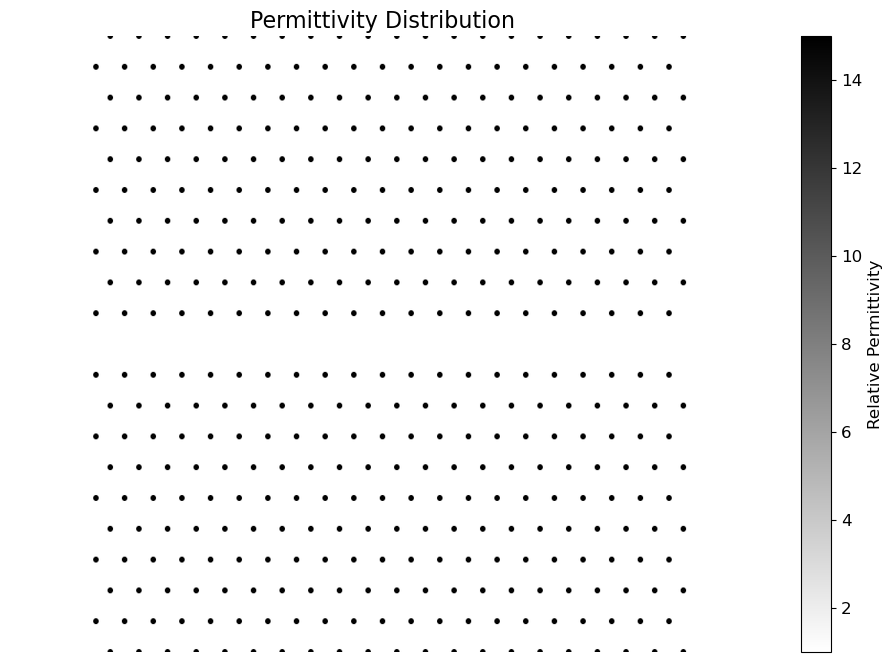

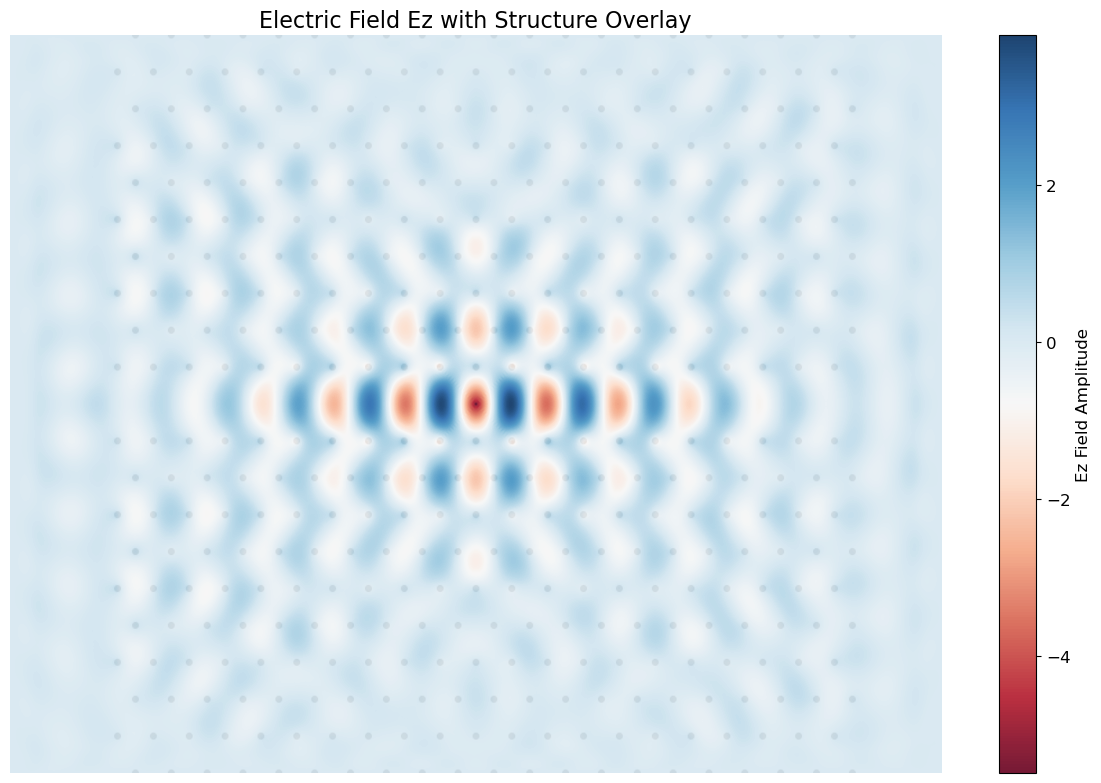

In [14]:
# Run continuous wave analysis
print("Setting up continuous wave simulation...")

# Create simulation
cw_sim = setup_continuous_wave_simulation(yig_params)

# Run simulation and extract data
eps_data, ez_data = run_continuous_wave_analysis(cw_sim, runtime=100)

# Create visualizations
fig_eps, fig_field = plot_field_distributions(eps_data, ez_data)

plt.show()

## 12 Comparison and Analysis

In [16]:
def compare_simulation_methods():
    """
    Compare the different simulation approaches used in this notebook.
    """
    print("Simulation Method Comparison:")
    print("=" * 60)
    print(f"{'Aspect':<20} {'Band Structure':<20} {'Continuous Wave':<20}")
    print("-" * 60)
    print(f"{'Source Type':<20} {'Gaussian Pulse':<20} {'Continuous Source':<20}")
    print(f"{'Analysis':<20} {'Frequency Domain':<20} {'Steady State':<20}")
    print(f"{'Geometry':<20} {'1D Array':<20} {'2D Photonic Crystal':<20}")
    print(f"{'Output':<20} {'Dispersion Bands':<20} {'Field Patterns':<20}")
    print(f"{'Application':<20} {'Band Gap Analysis':<20} {'Wave Propagation':<20}")
    print(f"{'K-points':<20} {'Multiple':<20} {'Single (Γ point)':<20}")
    print(f"{'Time Domain':<20} {'Transient':<20} {'Steady State':<20}")
    print("=" * 60)

# Run comparison
comparison_df = compare_simulation_methods()

Simulation Method Comparison:
Aspect               Band Structure       Continuous Wave     
------------------------------------------------------------
Source Type          Gaussian Pulse       Continuous Source   
Analysis             Frequency Domain     Steady State        
Geometry             1D Array             2D Photonic Crystal 
Output               Dispersion Bands     Field Patterns      
Application          Band Gap Analysis    Wave Propagation    
K-points             Multiple             Single (Γ point)    
Time Domain          Transient            Steady State        


Starting YIG dispersion analysis...

{'mu_b': 9.270862882873833e-24, 'gamma': 175824175824.17584, 'gamma_hz': 27983286697.47611, 'omega_pr': 28131868131.868134, 'nu_pr': 4477325871.596177, 'lambda_pr': 0.0670042808148448, 'f_meep': 0.799948889058517, 'gamma_meep': 27983286697.47611, 'sigma': 4981025032.150746, 'f_sigma': 0.8899431390776001, 'omega_s': 31296703296.703297, 'mu_x': 13.905709598032267, 'k_x': 12.336925804305192, 'denominator': 6.822055954515663e+19}
Running continuous wave analysis...
-----------
Initializing structure...
time for choose_chunkdivision = 7.41482e-05 s
Working in 2D dimensions.
Computational cell is 1 x 7 x 0 with resolution 16
     cylinder, center = (0,-3,0)
          radius 0.11, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (15,15,15)
     cylinder, center = (0,-2,0)
          radius 0.11, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (15,15,15)
     cylinder, center = (0,-1,0)
          rad

FloatProgress(value=0.0, description='0% done ', max=1.0)

creating output file "output/dispersion//eps-000000.00.h5"...
run 0 finished at t = 1.0 (32 timesteps)
Continuous wave analysis complete.
Figures saved to:
  - output/dispersion/epsilon_distribution_20250613_145633.png
  - output/dispersion/field_distribution_20250613_145633.png


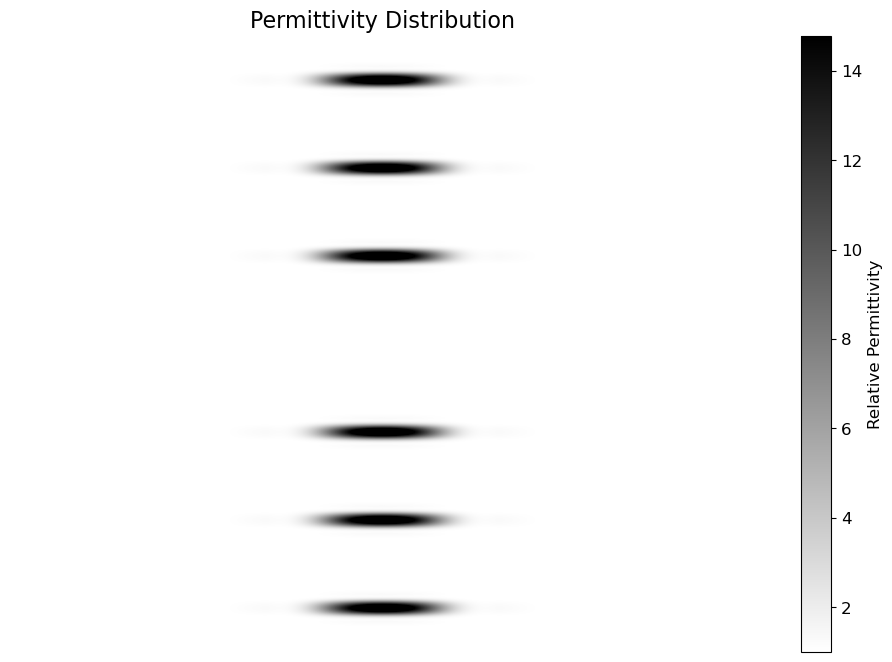

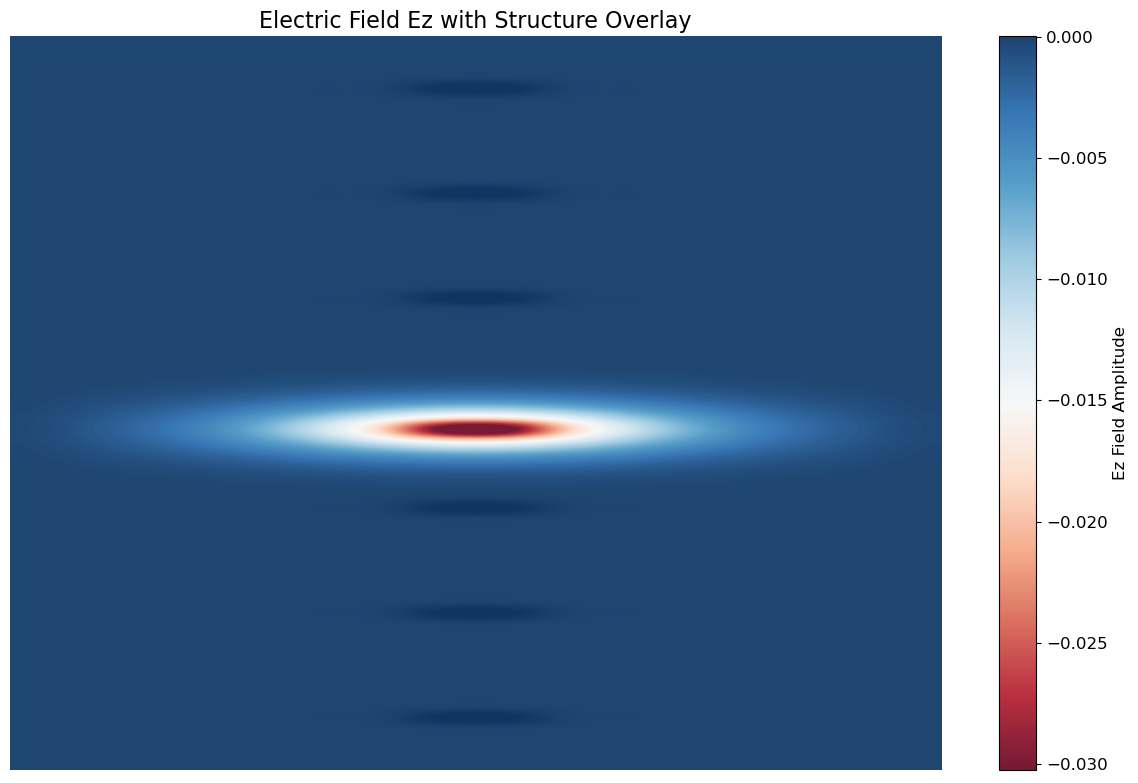

In [48]:
# Run the complete analysis
print("Starting YIG dispersion analysis...\n")

# Set up simulation
sim = setup_simulation(yig_params)

sim.use_output_directory(OUTPUT_DIR)
    
# Run simulation with field outputs
eps_data, ez_data = run_continuous_wave_analysis(sim, runtime=1)

fig_eps, fig_field = plot_field_distributions(eps_data, ez_data)

plt.show()

# Run dispersion analysis
# freqs_result = run_dispersion_analysis(sim, 20)

# # Plot results
# fig_dispersion, ax_dispersion = plot_dispersion(freqs_result)
# save_figure(fig_dispersion, "dispersion_diagram.png")

# plt.show()